## HOG + SVM Player detector
**This notebook aims to create a model to detect players**

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
from glob import glob
import scipy.io
import pandas as pd
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**1. Get the dataset**

In [3]:
#FIXME : Put it in a util.py file
def get_image_paths(data_path, fmt='jpg'):
    """
    This function returns lists containing the file path for each train 
    image, as well as lists with the label of each train image.
    :param data_path: path to the 'train' directories
    :param fmt: file extension of the images
    :return: lists: train_image_paths, train_labels
    """
    train_image_paths = []
    train_labels = []

    # train
    pth = os.path.join(data_path, '*.{:s}'.format(fmt))
    pth = glob(pth)
    train_image_paths.extend(pth)

    return train_image_paths

train_image_paths = get_image_paths("./dataset/DataSet_001")

In [4]:
#Now we get the labels 
mat_1 = scipy.io.loadmat('./dataset/annotation_1.mat')['annot'].flatten()

In [5]:
df_ground_truth = pd.DataFrame(mat_1)

In [6]:
#FIXME : Put it in a util.py file
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from skimage.transform import resize

H, W = 720, 1280
N = len(df_ground_truth)

def read_frame(train_image_paths, frame):
    file_path = train_image_paths[frame]
    img = cv2.imread(f"./dataset/DataSet_001/{file_path[0]}",cv2.IMREAD_GRAYSCALE)
    img = resize(img, output_shape=(H,W))
    return img

def annotations_for_frame(df_annotation, frame):
    assert frame in df_annotation.index
    bbs = df_annotation[df_annotation.index == frame].values[0]
    return bbs

def show_annotation(df_annotation, frame):
    img = read_frame(df_annotation['ImgName'], frame)
    bbs = annotations_for_frame(df_annotation['BBox'], frame)
    fig, ax = plt.subplots(figsize=(20, 12))
    print(type(ax))
    for x1, y1, x2, y2 in bbs:
        dx = x2 - x1
        dy = y2 - y1
        rect = patches.Rectangle((x1, y1), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """
    mask = np.zeros((H, W))
    for x1, y1, x2, y2 in bounding_boxes:
        dx = x2 - x1
        dy = y2 - y1
        mask[y1:y2,x1:x2] = 1
    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1
    
    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

**2. Show the dataset**

In [7]:
from ipywidgets import interact, widgets
from IPython.display import display

def f_display_frame(frame_id):
    show_annotation(df_ground_truth,frame_id)

interact(f_display_frame, frame_id=widgets.IntSlider(min=1, max=1493, step=1, value=1))

interactive(children=(IntSlider(value=1, description='frame_id', max=1493, min=1), Output()), _dom_classes=('w…

<function __main__.f_display_frame(frame_id)>

**3. Create the HOG descriptor (preprocess)**

In [8]:
df_ground_truth.shape

(1495, 2)

**3.1 Get the positive samples**

In [59]:
from IPython.display import clear_output
def getpos_sample(df_labels):
    pos_samples = []
    for i in range(0,1492):
        all_pos = df_labels[df_labels.index == i].values[0]
        path = df_labels[df_labels.index == i]["ImgName"].values[0]
        
        img = cv2.imread(f"./dataset/DataSet_001/{path[0]}")
        #img = resize(img, output_shape=(H,W,3))
        
        for pos in all_pos[0]:
            cropped_img = np.array(img[int(pos[1]):int(pos[3]),int(pos[0]):int(pos[2])])
            #cropped_img = resize(cropped_img, output_shape=(128,64,3))
            pos_samples.append(cropped_img) 
        clear_output(wait=True)
        print(f"{i+1}/{1492}")
        
    return pos_samples


In [60]:
pos_samples = getpos_sample(df_ground_truth)

1492/1492


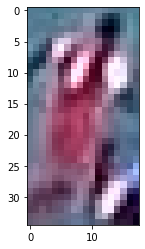

In [61]:
plt.imshow(pos_samples[1000])

**3.2 Get the negative samples**
To get the negative samples we take random crops of the dataset without players (from img nb 81 for exemple)

In [62]:
import random
def getneg_sample(df_labels):
    neg_sample = []
    random.seed(1)
    for i in range(0,1492):
        path = df_labels[df_labels.index == i]["ImgName"].values[0]
        
        img = cv2.imread(f"./dataset/DataSet_001/{path[0]}")
        #img = resize(img, output_shape=(H,W,3))
        
        y = int(random.random() * (H - 128))
        x = int(random.random() * (W - 64))
        
        cropped_img = np.array(img[y:y + 128, x:x + 64])
        neg_sample.append(cropped_img) 
        
        clear_output(wait=True)
        print(f"{i+1}/{1492}")
    return np.array(neg_sample)
    

In [63]:
neg_samples = getneg_sample(df_ground_truth)

1492/1492


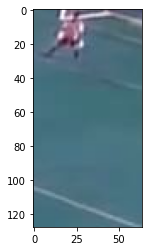

In [64]:
plt.imshow(neg_samples[100]) #Hoping rndom didn't select a player 

**3.3 Now the HOG**

In [65]:
#Calculate HOG features
def getHOGList(imageList):
    HOGList = []
    #hog = cv2.HOGDescriptor()
    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins
    
    for i in range(0,len(imageList)):
        '''file_path = train_image_paths[i]
        img = cv2.imread(f"{file_path}")'''
        hog = cv2.HOGDescriptor(_winSize=(imageList[i].shape[1] // cell_size[1] * cell_size[1],
                                  imageList[i].shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)
        gray = cv2.cvtColor(imageList[i], cv2.COLOR_BGR2GRAY)
        print(gray.shape)
        HOGList.append(hog.compute(gray))
        clear_output(wait=True)
        print(f"{i+1}/{len(imageList)}")
    return HOGList

In [66]:
#Get the HOG of the positive sample
positiv_HOG = getHOGList(pos_samples[:100])
print ("positiv_HOG", len(positiv_HOG))

100/100
positiv_HOG 100


In [67]:
#Add the label corresponding to all positive samples
labels = []
for _ in range(len(positiv_HOG)):
    labels.append(+1)

In [30]:
#len(np.array(positiv_HOG)) #BIZARRE

<ipython-input-30-cb0e7e04fe97>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  len(np.array(positiv_HOG)) #BIZARRE


100

In [68]:
#Get the hog for the neg samples
negativ_HOG = getHOGList(neg_samples[:100])
print ("negativ_HOG", len(negativ_HOG))

100/100
negativ_HOG 100


In [69]:
#concat pos and neg samples
hog_set = positiv_HOG
hog_set.extend(negativ_HOG)

In [74]:
len(hog_set[0])

504

In [71]:
for _ in range(len(negativ_HOG)):
    labels.append(-1)

**4. Let's create the SVM classifier**

In [72]:
#Get detector
def getHOGDetector(svm):
    sv = svm.getSupportVectors()
    rho, _, _ = svm.getDecisionFunction(0)
    sv = np.transpose(sv)
    return np.append(sv, [[-rho]], 0)

In [73]:
#FIXME : maybe try the svm from sklearn ..
#We create a first classifier
svm = cv2.ml.SVM_create()

svm.setCoef0(0.0)
svm.setDegree(3)
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 1000, 1e-3)#Termination condition
svm.setTermCriteria(criteria)
svm.setGamma(0)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setNu(0.5)
svm.setP(0.1)  # for EPSILON_SVR, epsilon in loss function?
svm.setC(0.01)  # From paper, soft classifier 
svm.setType(cv2.ml.SVM_EPS_SVR)  # C_SVC # EPSILON_SVR # may be also NU_SVR # do regression task
print(type(cv2.ml.ROW_SAMPLE))
svm.train(np.array(hog_set), cv2.ml.ROW_SAMPLE, np.array(labels))

<class 'int'>


<ipython-input-73-58ce7ef79425>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  svm.train(np.array(hog_set), cv2.ml.ROW_SAMPLE, np.array(labels))


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'train'
> Overload resolution failed:
>  - ml_StatModel.train() takes at most 2 arguments (3 given)
>  - samples data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'samples'


In [ ]:
svm

<ml_SVM 0x12fa1a7d0>

In [ ]:
'''#Get Hard example
def getHardExamples(negImageList, svm):
    hardNegList = []
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(getHOGDetector(svm))
    for i in range(len(negImageList)):
        rects, wei = hog.detectMultiScale(negImageList[i], winStride=(4, 4),padding=(8, 8), scale=1.05)
        for (x,y,w,h) in rects:
            hardExample = negImageList[i][y:y+h, x:x+w]
            hardNegList.append(cv2.resize(hardExample,(64,128)))
    return hardNegList'''

In [ ]:
'''#Acquire hard example based on initial training results
hardNegList = getHardExamples(neg_samples[:100], svm)
hosList.extend(getHOGList(hardNegList))
print ("hosList=====", len(hosList))
[labels.append(-1) for _ in range(len(hardNegList))]'''

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/objdetect/src/hog.cpp:121: error: (-215:Assertion failed) checkDetectorSize() in function 'setSVMDetector'


In [ ]:
#retrain with the hard exemple
svm.train(np.array(hog_set), cv2.ml.ROW_SAMPLE, np.array(labels))

#Save model
hog = cv2.HOGDescriptor()
hog.setSVMDetector(getHOGDetector(svm))
hog.save('myHogPlayerDector.bin')

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-yaf6rry6/opencv/modules/objdetect/src/hog.cpp:121: error: (-215:Assertion failed) checkDetectorSize() in function 'setSVMDetector'
